In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,StandardScaler,PolynomialFeatures
from sklearn.linear_model import Ridge,LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV,learning_curve, RandomizedSearchCV



In [37]:
df = pd.read_csv("csv/df_preparation.csv")

# Division du dataset en features et target

In [38]:
df.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_living_carre', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_above_carre', 'sqft_basement', 'sqft_basement_carre', 'zipcode',
       'sqft_living15', 'sqft_lot15', 'month', 'price'],
      dtype='object')

In [39]:
feature = df.columns[0:-1]
target = 'price'
X =df.drop(["price","month"],axis=1)
y = df[target]

In [40]:
X.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_living_carre', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_above_carre', 'sqft_basement', 'sqft_basement_carre', 'zipcode',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [41]:
numerical_features = [
       'bedrooms', 'bathrooms','floors','waterfront','view', 'condition', 'grade',
       'sqft_living', 'sqft_living_carre', 'sqft_lot','sqft_above',
       'sqft_basement','sqft_living15', 'sqft_lot15'
       ]
categorical_features = [
       
       'zipcode'
       ]

In [42]:
my_col_trans = ColumnTransformer([
    ("sclal",StandardScaler(),numerical_features),
    ("pol",PolynomialFeatures(),numerical_features),
    ("one_hot_encoder",OneHotEncoder(),categorical_features)
])

# Separation en données d'entrainement et de test

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10, train_size = 0.8)

# Modélisation

## Algorithme de régression linéaire Ridge

D'après ce lien https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

Recherche du meilleur parametre alpha.

In [44]:
# modelRid= make_pipeline(my_col_trans, Ridge(random_state=0))
# parameters = {"ridge__alpha":np.linspace(0,10,100)}
# randm_src = RandomizedSearchCV(estimator=modelRid, param_distributions = parameters,
#                                 n_iter = 50,scoring='r2')
# randm_src.fit(X_train, y_train)

# print(randm_src.best_params_)
# modelRid.set_params(**randm_src.best_params_)

Après plusieur test j'ai remarqué que alpha=7.5 est le parametre qui me permet d'avoir un bon score sur les données de test.

In [45]:
modelRid= make_pipeline(my_col_trans, Ridge(alpha=7.5,random_state=0))
modelRid.fit(X_train,y_train)
modelRid.score(X_train,y_train)

0.8653125652724971

In [46]:
modelRid.score(X_test,y_test)

0.8565833282958883

## Courbe d'apprentissage

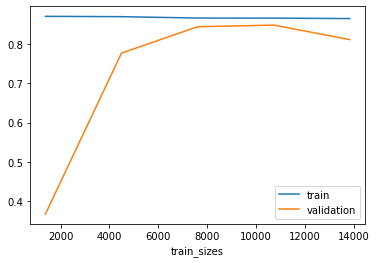

In [47]:

train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(modelRid,X_train,y_train,return_times=True)
                                           
                                           
plt.plot(train_sizes, train_scores.mean(axis=1), label='train')
plt.plot(train_sizes, test_scores.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()
plt.show()

## Comparaison entre prédiction et données reelles

In [48]:
y_pred = modelRid.predict(X_train)

In [49]:
residual = (y_pred - y_train).abs().sort_values()
print(residual)

9851     5.273876e+00
16276    1.045152e+01
21480    2.273188e+01
14997    2.364840e+01
8475     3.203559e+01
             ...     
9487     1.464469e+06
8638     1.577948e+06
10446    1.656831e+06
21050    1.765833e+06
12777    1.801234e+06
Name: price, Length: 17290, dtype: float64


In [50]:
residual.describe()

count    1.729000e+04
mean     8.158398e+04
std      1.054333e+05
min      5.273876e+00
25%      2.435745e+04
50%      5.283506e+04
75%      9.979690e+04
max      1.801234e+06
Name: price, dtype: float64

In [51]:
residual.quantile(0.99)

516624.6954674272

1% des valeurs se situe au dessus de 563064 $

/home/steven59/miniconda3/envs/sdp/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


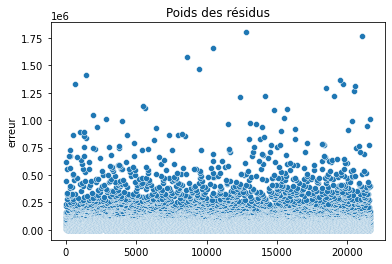

In [52]:
sns.scatterplot(residual.index, residual)
plt.title('Poids des résidus')
plt.ylabel('erreur')
plt.show()

### Supression des données dont la differences entre prédiction et prix réel est supperieur à 1 300 000 $

In [53]:
to_drop = residual[residual > 1300000].index

In [54]:
X_train = X_train.drop(to_drop)
y_train = y_train.drop(to_drop)

## Un nouvel entrainement

In [55]:
modelRid.fit(X_train,y_train)
modelRid.score(X_train,y_train)

0.8668969210723018

In [56]:
modelRid.score(X_test,y_test)

0.8582013244913497

## Nouvelle courbe d'apprentissage

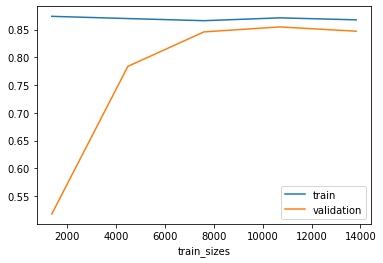

In [57]:

train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(modelRid,X_train,y_train,return_times=True)
                                           
                                           
plt.plot(train_sizes, train_scores.mean(axis=1), label='train')
plt.plot(train_sizes, test_scores.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()
plt.show()

# Export en csv

In [58]:
X_train.to_csv('csv/X_train.csv',index=False)
X_test.to_csv('csv/X_test.csv',index=False)
y_train.to_csv('csv/y_train.csv',index=False)
y_test.to_csv('csv/y_test.csv',index=False) 

# Sauvegarde du model

In [59]:
import pickle
pickle_out = open("modelRid.pkl", "wb") 
pickle.dump(modelRid, pickle_out) 
pickle_out.close()